In [233]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [234]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')
Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
pd.DataFrame(Xt[0:2])

,0,1,2,3
0,1.0,0.0,4.0,0.0
1,1.0,1.0,2.0,0.0


In [235]:
########### 1a Linear Regression by Hand #############

# insert intercept
intercept_column = np.ones((Xt.shape[0], 1), dtype=np.float64)
Xt_intercept = np.hstack((intercept_column, Xt))
print("Xt with intercept:")
print("Shape: ", Xt_intercept.shape)
print(Xt_intercept[0:2])

XTX = np.matmul(Xt_intercept.T,Xt_intercept)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, Xt_intercept.T)
w = np.matmul(XTXIXT,yt)

# Show the found weights
print("\nSolution of regression by hand: ")
print(w)
print(w.shape)

Xt with intercept:
Shape:  (200, 5)
[[1. 1. 0. 4. 0.]
 [1. 1. 1. 2. 0.]]

Solution of regression by hand: 
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]
(5,)


In [236]:
########### 1b Linear Regression with scikit #############

from sklearn.linear_model import LinearRegression
Xa = np.asarray(Xt_intercept)
ya = np.asarray(yt)
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(Xa,ya)
print("Solution of regression by hand: ")
print(model_skl.coef_)

Solution of regression by hand: 
[-8.49222821  2.4822138   2.95430727  4.64953914 -5.47160051]


In [237]:
########### 1c RMSE and NLL #############

intercept_column = np.ones((Xte.shape[0], 1), dtype=np.float64)
Xte_intercept = np.hstack((intercept_column, Xte))
print("Xte with intercept:")
print("Shape: ", Xte_intercept.shape)
print(Xte_intercept[0:2])

yte_pred = np.matmul(Xte_intercept, w)

# RMSE
MSE = np.mean((yte_pred - yte)**2)
RMSE_norm = np.sqrt(MSE)
print("\nRMSE: ", RMSE_norm)

# Varianz
residuals = yte_pred - yte
yte_pred_var = np.var(residuals)
print("Variance: ", yte_pred_var)

# NLL
NLL_norm = 0.5 * np.log(2 * np.pi * yte_pred_var) + 0.5 * np.mean((yte_pred - yte)**2) / yte_pred_var
print("NLL : ", NLL_norm)

Xte with intercept:
Shape:  (50, 5)
[[1. 0. 0. 3. 0.]
 [1. 1. 0. 3. 1.]]

RMSE:  8.588126386734231
Variance:  73.48030359919811
NLL :  3.5693226381682024


Mean Pred:  3.584986890619827
Variance Pred:  73.48030359919811


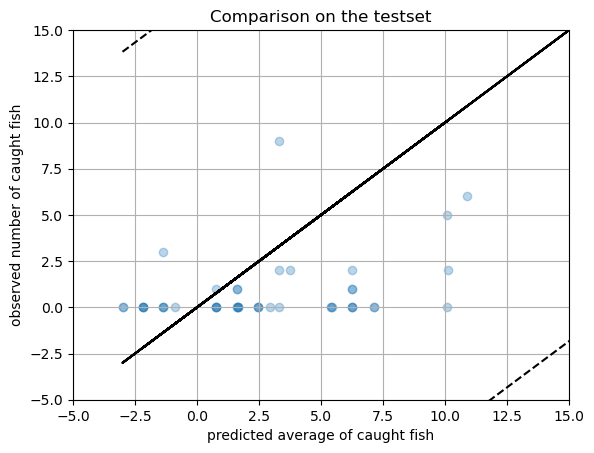

In [238]:
########### 1d Plot #############

# Compute mean of pred and real
mean_pred = np.mean(yte_pred)
print("Mean Pred: ", mean_pred)

var_pred = yte_pred_var
print("Variance Pred: ", var_pred)

sort_idx = np.argsort(yte_pred,axis=0)
yte_pred_sorted = yte_pred[sort_idx]
percentile025_pred = yte_pred_sorted - 1.96 * RMSE_norm
percentile975_pred = yte_pred_sorted + 1.96 * RMSE_norm

plt.scatter(yte_pred, yte,alpha=0.3)
plt.plot(yte_pred, yte_pred, c="black")
plt.plot(yte_pred_sorted, percentile025_pred, linestyle='dashed',c="black")
plt.plot(yte_pred_sorted, percentile975_pred, linestyle='dashed',c="black")

plt.grid(True)
plt.xlim(-5,15)
plt.ylim(-5,15)
plt.title('Comparison on the testset')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()

In [239]:
########### 1e Gradient Descent #############
import math

def poisson_nll(x, y, weights):
    mu = np.exp(np.matmul(x, weights))
    NLL = np.zeros_like(mu)
    for i in range(NLL.shape[0]):
        NLL[i] = - mu[i] + y[i] * np.log(mu[i]) - np.log(1.0 * math.factorial(int(y[i])))
    return np.mean(NLL) * -1

w = np.ones(5)
NLL = poisson_nll(Xt_intercept, yt, w)
print("NLL: ")
print(NLL)

NLL: 
1507.9856602262082


In [240]:
def gradient_descent_nll(x, y, weights):
    mu = np.exp(np.matmul(x,weights))
    ret = np.zeros_like(x)
    for i in range(x.shape[0]):
        mux = x[i] * mu[i]
        ret[i] = -mux + y[i] * x[i]
    return np.mean(ret, axis=0)

w = np.ones(5)
grads = np.round(gradient_descent_nll(Xt_intercept, yt, w), 2)
print("Gradienten:")
print(grads)

Gradienten:
[-1518.61 -1403.99 -1171.02 -5701.91 -3258.7 ]


In [241]:
epochs = 5000
lr = 0.001
w = np.ones(5)
hist = []

for i in range(epochs):
    loss = poisson_nll(Xt_intercept, yt, w)
    if i % 10:
        hist.append(loss)
    if i % 500 == 0:
        print("Epoche: ", i, '\t\tLoss: ', loss)
    grads = gradient_descent_nll(Xt_intercept, yt, w) #gradient wrt w
    w = w + lr * grads

print("\nTrained weights: ")
print(w)

Epoche:  0 		Loss:  1507.9856602262082
Epoche:  500 		Loss:  5.368843323918787
Epoche:  1000 		Loss:  4.167324197131499
Epoche:  1500 		Loss:  3.8602978965026176
Epoche:  2000 		Loss:  3.7306893512692034
Epoche:  2500 		Loss:  3.6567945847110117
Epoche:  3000 		Loss:  3.606422012945126
Epoche:  3500 		Loss:  3.568431731028144
Epoche:  4000 		Loss:  3.538082432151699
Epoche:  4500 		Loss:  3.5129828575559747

Trained weights: 
[-1.08852056  0.2597268   0.54509109  0.85448041 -1.65101241]


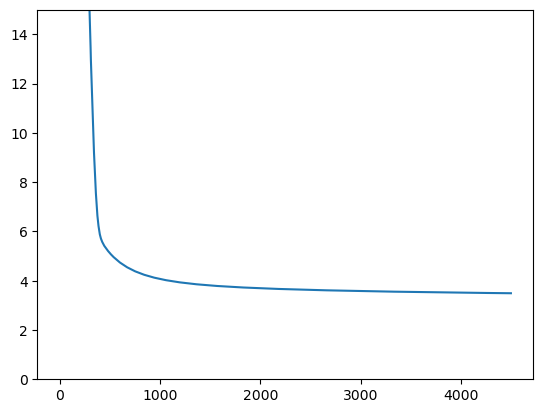

In [242]:
plt.plot(hist)
plt.ylim(0, 15)
plt.show()

In [243]:
yte_pred = np.exp(np.matmul(Xte_intercept, w))

# RMSE
MSE = np.mean((yte_pred - yte)**2)
RMSE_pois = np.sqrt(MSE)
print("RMSE: ", RMSE_pois, "\t\tbei c): ", RMSE_norm)

NLL_pois = poisson_nll(Xte_intercept, yte, w)
print("NLL: ", NLL_pois, "\t\tbei c): ", NLL_norm)

RMSE:  7.606839288683508 		bei c):  8.588126386734231
NLL:  3.0692866711267768 		bei c):  3.5693226381682024


2,5%-Quantile: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  4.  4.  4. 14. 14.]
97,5%-Quantile: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  5.  5.  5.  5.  5.  5.  5.  5.  5.  7.  7.  7.  8.
  8.  8.  8.  8.  8.  8.  8.  8.  8. 17. 17. 17. 33. 33.]


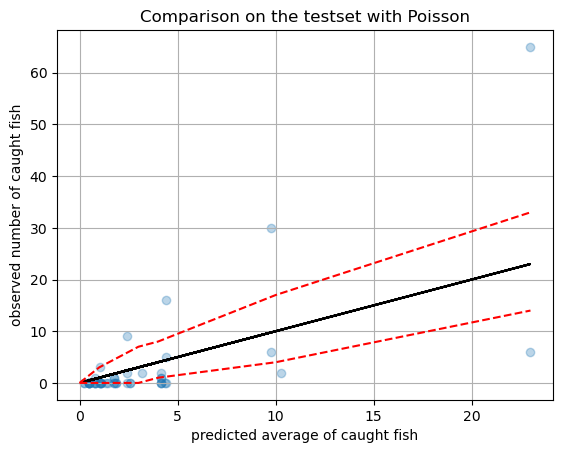

In [244]:
########### 1f Plot with Poison CPD #############
from scipy.stats import poisson

yte_pred = np.exp(np.matmul(Xte_intercept, w))

sort_idx = np.argsort(yte_pred,axis=0)
yte_pred_sorted = yte_pred[sort_idx]
yte_pred_sorted = np.round(yte_pred_sorted)

perc_025 = poisson(yte_pred_sorted).ppf(.025)
perc_975 = poisson(yte_pred_sorted).ppf(.975)
print("2,5%-Quantile:", perc_025)
print("97,5%-Quantile:", perc_975)

plt.scatter(yte_pred, yte,alpha=0.3)
plt.plot(yte_pred, yte_pred, c="black")
plt.plot(yte_pred_sorted, perc_025, linestyle='dashed', c="red")
plt.plot(yte_pred_sorted, perc_975, linestyle='dashed', c="red")

plt.grid(True)
plt.title('Comparison on the testset with Poisson')
plt.xlabel('predicted average of caught fish')
plt.ylabel('observed number of caught fish')
plt.show()